# Libraries

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 10.8 MB/s eta 0:00:00


In [ ]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import torch
import time
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    XLMRobertaTokenizer,
    EarlyStoppingCallback,
    TrainerCallback,
)

# Load Dataset

In [ ]:
# Path each dataset
dataset_path = "/content/balanced_english_data.csv"
singkatan_dict_path = "/content/abbrevations.csv"

# Load dataset utama
df = pd.read_csv(dataset_path)
# Load slang dictionary tanpa header, lalu beri nama kolom
slang_df = pd.read_csv("/content/abbrevations.csv", header=None, names=["Acronym", "Expansion"])

# Bersihkan spasi berlebih atau karakter aneh
slang_df["Acronym"] = slang_df["Acronym"].str.strip().str.lower()
slang_df["Expansion"] = slang_df["Expansion"].str.strip().str.lower()

# Buat dictionary
slang_dict = dict(zip(slang_df["Acronym"], slang_df["Expansion"]))

# Cek info dataset Indonesia
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9008 entries, 0 to 9007
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9008 non-null   object
 1   label   9008 non-null   object
dtypes: object(2)
memory usage: 140.9+ KB


# Data Pre-Processing

## 1. Class Distribution

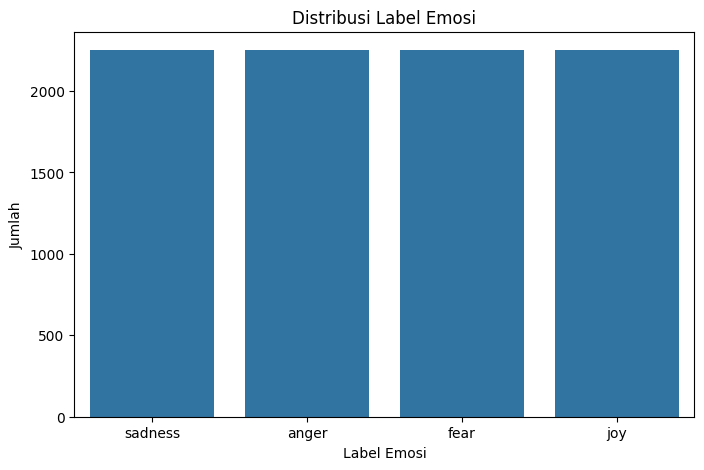

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df)
plt.title('Distribusi Label Emosi')
plt.xlabel('Label Emosi')
plt.ylabel('Jumlah')
plt.show()

## 2. Text Cleaning

In [ ]:
# Convert Emoji
def convert_emoji(text):
    text = emoji.demojize(text)
    text = text.replace(":", " ")
    text = text.replace("_", " ")
    return text

# Text Normalization
def normalize_text(text, slang_dict):
    pattern = r"\b(?:{})\b".format("|".join(re.escape(key) for key in slang_dict.keys()))

    def replace(match):
        word = match.group(0)
        return slang_dict.get(word.lower(), word)

    return re.sub(pattern, replace, text, flags=re.IGNORECASE)

# Noise Character Removal
def clean_text(text):
    text = re.sub(r'#(\w+)', r' \1 ', text)
    text = re.sub(r'@[\w_]+', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'[-/]', ' ', text)
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'\b\w*\d+\w*\b', '', text)
    text = re.sub(r'\.{3,}', 'elipsis', text)

    allowed_punct = '!?'
    text = ''.join(char for char in text if char.isalpha() or char.isspace() or char in allowed_punct or char == 'elipsis')

    text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace('elipsis', '...')
    return text

# Case Folding
def to_lowercase(text):
    return text.lower()

def preprocess_text(text, slang_dict):
    text = str(text)
    text = convert_emoji(text)
    text = normalize_text(text, slang_dict)
    text = clean_text(text)
    text = text.lower()
    return text

In [ ]:
# Backup kolom asli
df['text_original'] = df['text']

# Output per step
df['text_emoji'] = df['text_original'].apply(convert_emoji)
df['text_normalized'] = df['text_emoji'].apply(lambda x: normalize_text(x, slang_dict))
df['text_cleaned'] = df['text_normalized'].apply(clean_text)
df['text_lowercase'] = df['text_cleaned'].apply(to_lowercase)

# Simpan hasil akhir ke kolom final
df['text_clean'] = df['text_lowercase']


In [ ]:
df[['label', 'text_original', 'text_emoji', 'text_normalized', 'text_cleaned', 'text_lowercase', 'text_clean']].head(100)

,label,text_original,text_emoji,text_normalized,text_cleaned,text_lowercase,text_clean
0,sadness,"@modelady24 I know, right? I had a tinge of th...","@modelady24 I know, right? I had a tinge of th...","@modelady24 I know, right? I had a tinge of th...",I know right? I had a tinge of the same though...,i know right? i had a tinge of the same though...,i know right? i had a tinge of the same though...
1,anger,Vale! Vale! Sip sangria and taste tantalizing ...,Vale! Vale! Sip sangria and taste tantalizing ...,Vale! Vale! Sip sangria and taste tantalizing ...,Vale! Vale! Sip sangria and taste tantalizing ...,vale! vale! sip sangria and taste tantalizing ...,vale! vale! sip sangria and taste tantalizing ...
2,sadness,"So I tried to give her time to sober up, while...","So I tried to give her time to sober up, while...",significant other I tried to give her time to ...,significant other I tried to give her time to ...,significant other i tried to give her time to ...,significant other i tried to give her time to ...
3,fear,"@Meruna_ as a musician, I can tell you that m...","@Meruna as a musician, I can tell you that m...","@Meruna as a musician, I can tell you that m...",as a musician I can tell you that more people ...,as a musician i can tell you that more people ...,as a musician i can tell you that more people ...
4,joy,You know you're in love when all you can do is...,You know you're in love when all you can do is...,You know you're in love when all you can do is...,You know youre in love when all you can do is ...,you know youre in love when all you can do is ...,you know youre in love when all you can do is ...
...,...,...,...,...,...,...,...
95,anger,Follow me on Snapchat 👻 Carlabtst15 #snapchat,Follow me on Snapchat ghost Carlabtst15 #sna...,Follow me on Snapchat ghost Carlabtst15 #sna...,Follow me on Snapchat ghost snapchat,follow me on snapchat ghost snapchat,follow me on snapchat ghost snapchat
96,joy,"@BlueJayHunter I'm fine on the near future, I ...","@BlueJayHunter I'm fine on the near future, I ...","@BlueJayHunter I'm fine on the near future, I ...",Im fine on the near future I just want to go t...,im fine on the near future i just want to go t...,im fine on the near future i just want to go t...
97,fear,Transform your hardship(s) into a burning #des...,Transform your hardship(s) into a burning #des...,Transform your hardship(s) into a burning #des...,Transform your hardships into a burning desire...,transform your hardships into a burning desire...,transform your hardships into a burning desire...
98,sadness,i lost my wallet lol.... again....,i lost my wallet lol.... again....,i lost my wallet laughing out loud.... again....,i lost my wallet laughing out loud... again...,i lost my wallet laughing out loud... again...,i lost my wallet laughing out loud... again...


## 3. Label Encoding

In [ ]:
emotion_dict = {'anger': 0, 'joy': 1, 'fear': 2, 'sadness': 3}
df['label'] = df['label'].apply(lambda x: emotion_dict[x])

## 4. Tokenizing

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

def tokenize_function(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=128)

encoded_df = df['text_clean'].apply(tokenize_function)
df['input_ids'] = encoded_df.apply(lambda x: x['input_ids'])
df['attention_mask'] = encoded_df.apply(lambda x: x['attention_mask'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
# Output Tokenizer
sample_text = df['text_clean'].iloc[95]
encoded_sample = tokenizer(sample_text, truncation=True, padding="max_length", max_length=128)

print("Original Clean Text:")
print(sample_text)

print("\nInput IDs:")
print(encoded_sample['input_ids'])

print("\nTokens:")
print(tokenizer.convert_ids_to_tokens(encoded_sample['input_ids']))

print("\nAttention Mask:")
print(encoded_sample['attention_mask'])

Original Clean Text:
follow me on snapchat ghost snapchat

Input IDs:
[0, 28960, 163, 98, 76685, 21393, 706, 40294, 76685, 21393, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Tokens:
['<s>', '▁follow', '▁me', '▁on', '▁snap', 'chat', '▁g', 'host', '▁snap', 'chat', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

# Build Model

## Split Dataset

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Cek hasil split
print(f"Jumlah train_data: {len(train_df)}")
print(f"Jumlah data val: {len(val_df)}")

Jumlah train_data: 7206
Jumlah data val: 1802


In [ ]:
# Convert ke Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

## Load Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

## Epoch 3

In [ ]:
def get_patience(total_epoch):
    return min(2, total_epoch // 3)

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
    }

training_args = TrainingArguments(
    output_dir="./results_epoch3",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs_epoch3",
    logging_steps=10,
    load_best_model_at_end=True,
    dataloader_drop_last=False,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="tensorboard",
)

patience_value = get_patience(training_args.num_train_epochs)
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=patience_value
)

class TimestampCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, args, state, control, **kwargs):
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        print(f"Epoch {state.epoch} completed in {epoch_duration:.2f} seconds.")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping, TimestampCallback],
)


<ipython-input-18-20963c2f7889>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.600000,0.499914,0.826304
2,0.459900,0.383674,0.872919
3,0.193900,0.330956,0.900666


Epoch 1.0 completed in 91.72 seconds.
Epoch 2.0 completed in 92.33 seconds.
Epoch 3.0 completed in 92.52 seconds.


TrainOutput(global_step=1353, training_loss=0.5745981020656058, metrics={'train_runtime': 365.9755, 'train_samples_per_second': 59.07, 'train_steps_per_second': 3.697, 'total_flos': 1422009233528832.0, 'train_loss': 0.5745981020656058, 'epoch': 3.0})

### Confusion Matrix

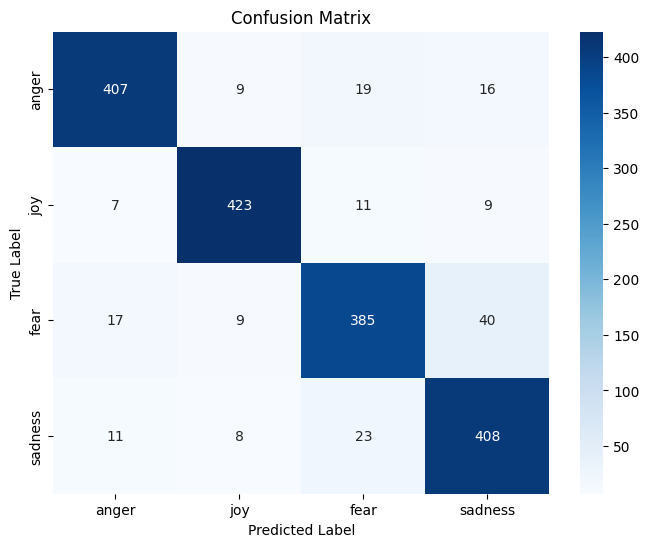

In [ ]:
# Confusion matrix
preds_output = trainer.predict(val_dataset)
true_labels = preds_output.label_ids
predicted_labels = np.argmax(preds_output.predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
labels = ['anger', 'joy', 'fear', 'sadness']

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Accuracy

In [ ]:
predictions = trainer.predict(val_dataset)
true_labels = predictions.label_ids
predicted_probs = predictions.predictions
predicted_labels = np.argmax(predicted_probs, axis=1)

# Classification Report
print("=== Classification Report ===")
print(classification_report(true_labels, predicted_labels, digits=6))

# Akurasi
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.6f}")

=== Classification Report ===
              precision    recall  f1-score   support

           0   0.920814  0.902439  0.911534       451
           1   0.942094  0.940000  0.941046       450
           2   0.878995  0.853659  0.866142       451
           3   0.862579  0.906667  0.884074       450

    accuracy                       0.900666      1802
   macro avg   0.901121  0.900691  0.900699      1802
weighted avg   0.901119  0.900666  0.900686      1802

Accuracy: 0.900666


## Epoch 5

In [ ]:
def get_patience(total_epoch):
    return min(2, total_epoch // 3)

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
    }

training_args = TrainingArguments(
    output_dir="./results_epoch5",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs_epoch5",
    logging_steps=10,
    load_best_model_at_end=True,
    dataloader_drop_last=False,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="tensorboard",
)

patience_value = get_patience(training_args.num_train_epochs)
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=patience_value
)

class TimestampCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, args, state, control, **kwargs):
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        print(f"Epoch {state.epoch} completed in {epoch_duration:.2f} seconds.")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping, TimestampCallback],
)


<ipython-input-23-b03166bacfa0>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.276300,0.441763,0.903996
2,0.163600,0.382085,0.917869
3,0.120200,0.376902,0.917314


Epoch 1.0 completed in 91.92 seconds.
Epoch 2.0 completed in 92.54 seconds.
Epoch 3.0 completed in 92.51 seconds.


TrainOutput(global_step=1353, training_loss=0.2088426039867373, metrics={'train_runtime': 392.7377, 'train_samples_per_second': 91.741, 'train_steps_per_second': 5.742, 'total_flos': 1422009233528832.0, 'train_loss': 0.2088426039867373, 'epoch': 3.0})

### Confusion Matrix

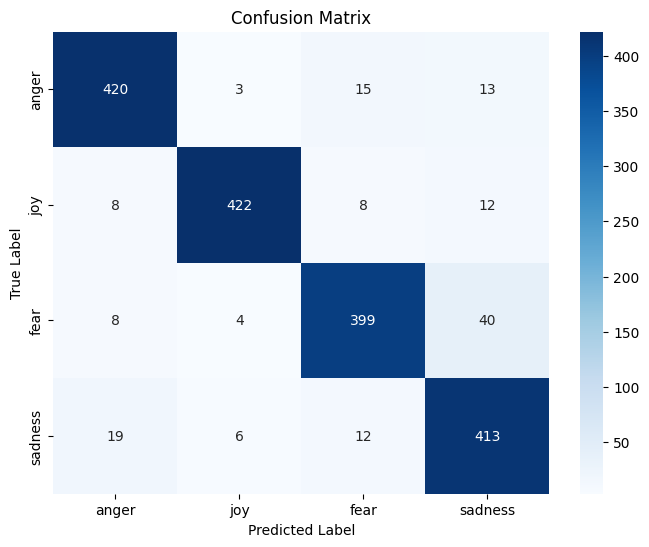

In [ ]:
# Confusion matrix
preds_output = trainer.predict(val_dataset)
true_labels = preds_output.label_ids
predicted_labels = np.argmax(preds_output.predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
labels = ['anger', 'joy', 'fear', 'sadness']

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Accuracy

In [ ]:
predictions = trainer.predict(val_dataset)
true_labels = predictions.label_ids
predicted_probs = predictions.predictions
predicted_labels = np.argmax(predicted_probs, axis=1)

# Classification Report
print("=== Classification Report ===")
print(classification_report(true_labels, predicted_labels, digits=6))

# Akurasi
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.6f}")

=== Classification Report ===
              precision    recall  f1-score   support

           0   0.923077  0.931264  0.927152       451
           1   0.970115  0.937778  0.953672       450
           2   0.919355  0.884701  0.901695       451
           3   0.864017  0.917778  0.890086       450

    accuracy                       0.917869      1802
   macro avg   0.919141  0.917880  0.918151      1802
weighted avg   0.919143  0.917869  0.918147      1802

Accuracy: 0.917869


## Epoch 10

In [ ]:
def get_patience(total_epoch):
    return min(2, total_epoch // 3)

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
    }

training_args = TrainingArguments(
    output_dir="./results_epoch10",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs_epoch10",
    logging_steps=10,
    load_best_model_at_end=True,
    dataloader_drop_last=False,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="tensorboard",
)

patience_value = get_patience(training_args.num_train_epochs)
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=patience_value
)

class TimestampCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, args, state, control, **kwargs):
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        print(f"Epoch {state.epoch} completed in {epoch_duration:.2f} seconds.")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping, TimestampCallback],
)


<ipython-input-28-40edfbb62420>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.094500,0.423974,0.917869
2,0.261600,0.423448,0.920089
3,0.182700,0.368473,0.925083
4,0.091200,0.347442,0.930078
5,0.057000,0.362090,0.931188
6,0.051000,0.363635,0.934517
7,0.057700,0.370363,0.933962
8,0.077300,0.382652,0.931743


Epoch 1.0 completed in 91.79 seconds.
Epoch 2.0 completed in 92.51 seconds.
Epoch 3.0 completed in 92.28 seconds.
Epoch 4.0 completed in 92.27 seconds.
Epoch 5.0 completed in 92.42 seconds.
Epoch 6.0 completed in 92.32 seconds.
Epoch 7.0 completed in 92.36 seconds.
Epoch 8.0 completed in 92.26 seconds.


TrainOutput(global_step=3608, training_loss=0.11657478251884755, metrics={'train_runtime': 994.1115, 'train_samples_per_second': 72.487, 'train_steps_per_second': 4.537, 'total_flos': 3792024622743552.0, 'train_loss': 0.11657478251884755, 'epoch': 8.0})

### Confusion Matrix

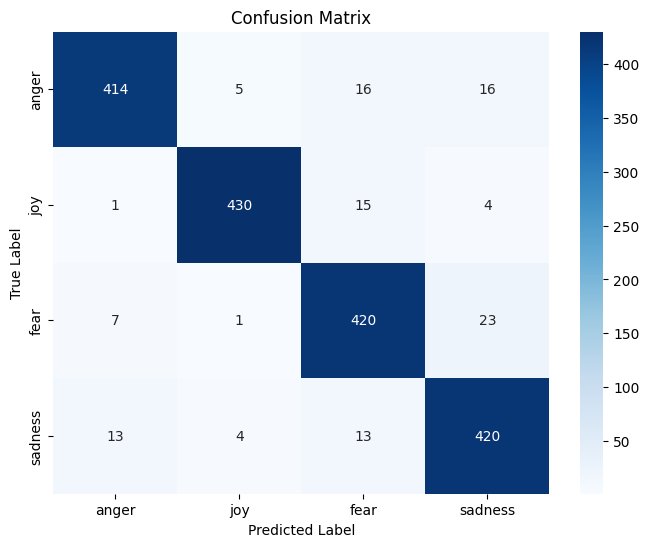

In [ ]:
# Confusion matrix
preds_output = trainer.predict(val_dataset)
true_labels = preds_output.label_ids
predicted_labels = np.argmax(preds_output.predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
labels = ['anger', 'joy', 'fear', 'sadness']

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Accuracy

In [ ]:
predictions = trainer.predict(val_dataset)
true_labels = predictions.label_ids
predicted_probs = predictions.predictions
predicted_labels = np.argmax(predicted_probs, axis=1)

# Classification Report
print("=== Classification Report ===")
print(classification_report(true_labels, predicted_labels))

# Akurasi
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.6f}")

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       451
           1       0.98      0.96      0.97       450
           2       0.91      0.93      0.92       451
           3       0.91      0.93      0.92       450

    accuracy                           0.93      1802
   macro avg       0.94      0.93      0.93      1802
weighted avg       0.94      0.93      0.93      1802

Accuracy: 0.934517
